# Segundo Projeto de Inteligência Artificial

*   Inteligência Artificial - Busca

*   Felipe Daniel Dias dos Santos - 11711ECP004

*   Graduação em Engenharia de Computação - Faculdade de Engenharia Elétrica - Universidade Federal de Uberlândia

## Importação das bibliotecas

In [ ]:
#Importando as bibliotecas
import time
import random
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from scipy import stats
from sklearn import datasets
from sklearn.utils import resample
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

## Módulo States

Definição de funções auxiliares e operadores para a manipulação de estados, utilizadas pelas metaheurísticas

In [ ]:
#Função para gerar uma lista de classificadores, dado um estado. Os classificadores retornados serão aqueles das posições
#do estado cujo valor seja 1. Então, por exemplo, para state = [1, 0, 1] e classifiers = [cl1, cl2 e cl3], o resultado será [cl1, cl3]
def getClassifiers(state, classifiers):

    return [classifiers[i] for i in range(len(state)) if state[i] == 1]

In [ ]:
#Função para gerar um estado inicial aleatoriamente
def generateInitialState(classifiers):
    
    return [random.randint(0, 1) for _ in range(len(classifiers))]

In [ ]:
#Função para gerar um conjunto de estados dado um estado inicial
def generateStates(initial_state):

    states = []

    for i in range(len(initial_state)):

        aux_states = initial_state.copy()

        #Devido ao fato do vetor ser binário (presença ou ausência de determinado classificador), somente se uma posição do estado 
        #é 0, a mesma será incrementada
        if initial_state[i] == 0:

            aux_states[i] = 1 
            states.append(aux_states)
      
    return states

In [ ]:
#Função para mudança de estado, incrementando ou decrementando uma certa posição do estado, obedecendo as regras de binaridade do estado
def changeState(state, position, value):

    #O valor será aplicado à posição do estado somente se o estado permanecer binário após a operação
    if (state[position] == 0 and value == -1) or (state[position] == 1 and value == 1):

        return []

    state[position] += value

    return state

In [ ]:
#Função para gerar a vizinhança de um determinado estado, incrementado valores inexistentes e decrementando os existentes
def generateNeighborhood(state):

    neighborhood = []

    #Gerando os vizinhos com incrementação dos estados nulos
    for i in range(len(state)):

        aux_state = state.copy()
        new_state = changeState(aux_state, i, 1)

        if new_state != []:
      
            neighborhood.append(new_state)
   
    #Gerando os vizinhos com decremento dos estados unitários
    for i in range(len(state)):
   
        aux_state = state.copy()
        new_state = changeState(aux_state, i, -1)

        if new_state != []:
   
            neighborhood.append(new_state)
   
    return neighborhood

In [ ]:
#Função para calcular a acurácia de uma configuração específica de classificadores, de acordo com as regras do Heterogeneous Pooling
def evaluateState(hp, test, state, classifiers):

    x_test = [t[:-1] for t in test]
    y_test = [t[-1] for t in test]
    
    selected_classifiers = getClassifiers(state, classifiers)
    
    #Para um vetor sem classificadores, a acurácia é nula
    if selected_classifiers == []:
        
        return 0

    return hp.score(x_test, y_test, selected_classifiers)

In [ ]:
#Função para escolher um estado de maneira aleatória
def randomState(states):
  
    return states[random.randint(0, len(states) - 1)]

## Módulo Roulette

Definição de funções para a geração e execução de uma roleta, utilizadas pelo algoritmo genético

In [ ]:
#Função para a construção de uma roleta, dados os estados e seus valores (nesse caso, as acurácias de cada estado)
def rouletteConstruction(states):

    acc_value = 0
    aux_states = []
    roulette = []
    total_value = sum([state[0] for state in states])

    #Determinação da proporção do valor de cada estado em relação a soma dos valores
    for state in states:
        
        if total_value != 0:

            ratio = state[0] / total_value

        else:

            ratio = 1

        aux_states.append((ratio, state[1]))
 
    #Determinando a proporção acumulada de cada estado
    for state in aux_states:
    
        acc_value += state[0]
        roulette.append((acc_value, state[1]))
    
    return roulette

In [ ]:
#Função que implementa o ato de "girar a roleta", isto é, determina algum estado aleatoriamente, levando em conta o peso de cada estado
def rouletteRun(rounds, roulette):

    if roulette == []:

        return []

    selected = []

    #A roleta será girada rounds vezes, onde cada rodada seleciona algum estado, levando em conta sua proporção no valor total
    while len(selected) < rounds:

        rand = random.uniform(0, 1)

        for state in roulette:

            if rand <= state[0]:

                selected.append(state[1])
                break
    
    return selected

## Módulo Population

Definição de funções auxiliares e operadores para a manipulação de populações, utilizadas pelo algoritmo genético

In [ ]:
#Função para geração de uma população inicial
def initialPopulation(population_size, classifiers):
    
    return [generateInitialState(classifiers) for _ in range(population_size)]

In [ ]:
#Função para avaliar uma dada população, calculando a acurácia de cada indivíduo
def evaluatePopulation(hp, test, population, classifiers):

    return [(evaluateState(hp, test, individual, classifiers), individual) for individual in population]

In [ ]:
#Função para gerar uma nova população, dada uma primeira. A seleção é avaliada de acordo com uma roleta, construída considerando
#a acurácia de cada indivíduo e, portanto, selecionando os mais aptos
def selection(value_population, population_size):

    aux_population = rouletteConstruction(value_population)

    return rouletteRun(population_size, aux_population)

In [ ]:
#Função que retorna o primeiro valor de um elemento
def first(x):
    
    return x[0]

In [ ]:
#Função para determinar os melhores indivíduos que estarão isentos da seleção, garantidos para a próxima geração
def elitism(val_population, pct):
    
    #Aproximadamente pct% da população será selecionada para compor a elite
    n = math.floor((pct / 100) * len(val_population))
    
    if n < 1:
    
        n = 1
    
    #Os n melhores indivíduos serão retornados
    val_elite = sorted(val_population, key = first, reverse = True)[:n]
    
    return [s for v, s in val_elite]

In [ ]:
#Função para verificar se uma população convergiu, isto é, se todos os indivíduos são iguais
def convergent(population):

    if population == []:

        return False
    
    base = population[0]
    
    #Compara-se o primeiro indivíduo com o resto da população. Na primeira igualdade negativa, sabemos que a população ainda não convergiu
    for i in range(len(population)):
    
        if base != population[i]:
    
            return False
    
    return True

## Módulo Genetics

Definição de funções auxiliares e operadores genéticos utilizadas pelo algoritmo genético

In [ ]:
#Função que realiza o crossover entre os genes de dois indivíduos (pais), gerando um outro indivíduo (filho)
#Cada alelo do gene resultante será determinado aleatoriamente, com igual probabilidade, dos indivíduos pais
def crossover(parent1, parent2):

    child1 = []
    child2 = []
    
    #Para cada alelo, existe igual chance de herdar o gene do pai ou da mãe
    #Se um filho recebe o gene do pai, o outro recebe o da mãe    
    for i in range(len(parent1)):
                
        if random.randint(0, 1) == 0:
        
            child1.append(parent1[i])
            child2.append(parent2[i])
        
        else:
            
            child1.append(parent2[i])
            child2.append(parent1[i])

    return child1, child2

In [ ]:
#Função que realiza mutação em um indivíduo
def mutation(individual):

    mutated = individual.copy()
    rand = random.randint(0, len(mutated) - 1)

    #O alelo a ser mutado, selecionado aleatoriamente, irá decrementar, se for 1, ou incrementar, se for 0
    if mutated[rand] == 0:
 
        mutated[rand] += 1

    else:

        mutated[rand] -= 1
        
    return mutated

In [ ]:
#Função que realiza o crossover em uma população, dada uma taxa de crossover
def crossoverStep(population, crossover_ratio):
    
    new_population = []
    tam_population = len(population)
    
    #Gerando a nova população após a etapa de crossover
    for _ in range(round(tam_population / 2)):
        
        #Selecionando os pais da vez de maneira aleatória
        parent1 = population[random.randint(0, tam_population - 1)] 
        parent2 = population[random.randint(0, tam_population - 1)]

        #Determinando se haverá crossover ou não
        if random.uniform(0, 1) <= crossover_ratio:
            
            child1, child2 = crossover(parent1, parent2)            
            
        else:
        
            child1, child2 = parent1, parent2
                
        new_population += [child1, child2]
        
    return new_population

In [ ]:
#Função que realiza mutação em uma população, dada uma taxa de mutação
def mutationStep(population, mutation_ratio):
    
    new_population = []
    
    #Cada indivíduo terá uma chance de sofrer mutação
    for individual in population:

        if random.uniform(0, 1) <= mutation_ratio:
       
            new_population.append(mutation(individual))
        
        else:
            
            new_population.append(individual)
        
    return new_population

## Módulo Metaheuristics

Definição de funções que implementam metaheurísticas que determinam uma combinação de classificadores

In [ ]:
#Função para determinar se algum valor será selecionado em relação a algum melhor valor
def changeProbability(value, best_value, t):

    p = 1 / (math.exp(1) ** ((best_value - value) / t))
    r = random.uniform(0, 1)
    
    return r < p

In [ ]:
#Função que implementa a metaheurística Hill Climbing
def hillClimbing(hp, test, classifiers):
    
    #Parâmetros de configuração do tempo: o algoritmo irá ser executado por, no máximo, 120 segundos, aproximadamente
    start = time.process_time()
    max_time = 120
    end = 0
    
    #Parâmetros iniciais do algoritmo: o estado inicial e o estado ótimo é o vetor nulo e o valor ótimo é 0
    current_state = [0] * len(classifiers)
    optimal_value = 0
    optimal_state = current_state
    better = True

    #Enquanto o tempo não atingir o máximo e houverem estados melhores, o algoritmo é executado
    while better and end - start <= max_time:
        
        better = False
        
        #Gerando os estados possíveis a partir do estado atual
        possible_states = generateStates(current_state)

        #Cada novo estado é analisado
        for state in possible_states:
        
            aux_val = evaluateState(hp, test, state, classifiers)
            
            #Se o valor do estado corrente é o melhor, o valor e estado ótimos são atualizados
            #Além disso, o melhor da rodada se torna o estado atual
            if aux_val >= optimal_value:
        
                optimal_value = aux_val
                optimal_state = state
                current_state = state
                better = True

        end = time.process_time()

    #Retornando a lista de classificadores, dado o estado ótimo
    return getClassifiers(optimal_state, classifiers)

In [ ]:
#Função que implementa a metaheurística Simulated Annealing
def simulatedAnnealing(hp, test, classifiers):

    #Parâmetros de configuração do tempo: o algoritmo irá ser executado por, no máximo, 120 segundos, aproximadamente, e por 10 iterações    
    start = time.process_time()
    max_time = 120
    end = 0
    max_iter = 10
    
    #Hiperparâmetros do algoritmo: a temperatura é igual a 200 e a taxa de redução da temperatura é igual a 0.1
    t = 200
    alfa = 0.1
    
    #Parâmetros iniciais do algoritmo: o estado inicial é gerado aleatoriamente, o estado ótimo é o estado inicial e o valor ótimo
    #é o valor do estado inicial
    current_state = generateInitialState(classifiers)
    optimal_state = current_state
    optimal_value = evaluateState(hp, test, optimal_state, classifiers)
    
    #O algoritmo executa enquanto o tempo não tiver se esgotado e a temperatura maior ou igual a 1
    while t >= 1 and end - start <= max_time:        
        
        #Através de max_iter execuções, o algoritmo é executado gerando a vizinhança do estado atual e a avaliando
        #Estados que não sejam melhores que o estado atual ainda possuem probabilidade de serem selecionados 
        for _ in range(max_iter):    
            
            neighborhood = generateNeighborhood(current_state)
            
            #Se não existe vizinhança, o algoritmo finaliza, retornando os classificadores do estado ótimo
            if neighborhood == []:
            
                return getClassifiers(optimal_state, classifiers)             
            
            #Seleciona-se um estado da vizinhança de maneira aleatória e avalia o mesmo
            aux_state = randomState(neighborhood)
            aux_value = evaluateState(hp, test, aux_state, classifiers)
            
            #Avaliando o estado atual
            current_state_value = evaluateState(hp, test, current_state, classifiers)
            
            #Se o vizinho selecionado for melhor que o estado atual, ele se torna o estado atual
            if aux_value > current_state_value:
                
                current_state = aux_state
                
                #Ainda, se o estado recém selecionado for o melhor, o estado e valor ótimos são atualizados
                if aux_value > optimal_value:
                
                    optimal_state = aux_state
                    optimal_value = aux_value
            
            #Se o vizinho não for melhor que o estado atual, ainda há uma chance de ser selecionado
            else:
                
                if changeProbability(aux_value, current_state_value, t):
                
                    current_state = aux_state
        
        #Decrescimento da temperatura por uma taxa de alfa
        t *= alfa
        end = time.process_time()

    #Retornando a lista de classificadores, dado o estado ótimo
    return getClassifiers(optimal_state, classifiers)

In [ ]:
#Função que implementa a metaheurística Genetic Algorithm
def geneticAlgorithm(hp, test, classifiers):

    #Parâmetros de configuração do tempo: o algoritmo irá ser executado por, no máximo, 120 segundos, aproximadamente
    start = time.process_time()
    max_time = 120
    end = 0
    
    #Hiperparâmetros do algoritmo: o algoritmo é executado por, no máximo, 200 gerações, a população possui 100 indivíduos, a taxa 
    #de crossover é de 0.9, a taxa de mutação é de 0.1 e a porcentagem de indivíduos elite é de 20%
    max_generation = 200
    current_generation = 0
    population_size = 100
    crossover_ratio = 0.9
    mutation_ratio = 0.1
    elite_pct = 20
    
    #Parâmetros iniciais do algoritmo: a população inicial é gerada aleatoriamente, o estado ótimo é o vetor nulo, o valor ótimo é 0
    #e a convergência é definida de acordo com a população atual
    current_population = initialPopulation(population_size, classifiers)
    optimal_state = [0] * len(classifiers)
    optimal_value = 0
    conv = convergent(current_population)

    #O algoritmo é executado enquanto não for atingido o limite de tempo e de iterações e a população não convergir
    while not conv and current_generation < max_generation and end - start <= max_time:
        
        #Avaliando a população atual
        val_current_population = evaluatePopulation(hp, test, current_population, classifiers)
        
        #Gerando a população elite e seu melhor indivíduo e avaliando-o
        elite_population = elitism(val_current_population, elite_pct)
        best = elite_population[0]
        val_best = evaluateState(hp, test, best, classifiers)

        #O estado e valor ótimo são atualizados se o melhor indivíduo da população atual for o melhor entre as passadas gerações
        if val_best > optimal_value:
          
            optimal_state = best
            optimal_value = val_best

        #Preparando a população para gerar a nova geração: os indivíduos serão selecionados, sofrerão crossover e mutação (com certa
        #probabilidade). Ao fim, a nova geração conterá os indivíduos resultantes mais os indivíduos elite
        selected = selection(val_current_population, population_size - len(elite_population)) 
        crossed = crossoverStep(selected, crossover_ratio)
        mutated = mutationStep(crossed, mutation_ratio)
        current_population = elite_population + mutated
        conv = convergent(current_population)
        current_generation += 1
        end = time.process_time()
    
    #Retornando a lista de classificadores, dado o estado ótimo
    return getClassifiers(optimal_state, classifiers)

## Módulo HP:

Definição do classificador Heterogeneous Pooling através dos métodos fit, predict e score, onde o combinado é determinado pelos métodos do módulo Metaheuristic

In [ ]:
#Classificador Heterogeneous Pooling
class HPClassifier(BaseEstimator):

    #Inicialização do HP com determinada metaheurística
    def __init__(self, heuristic = None, n_samples = None):
        
        super().__init__()
        self.n_samples = n_samples
        self.heuristic = heuristic
        self.resample_random_state = -1
        self.classes_count = None
    
    #Método fit do HP
    def fit(self, x_train, y_train):
        
        #Ordenando o vetor de classes de maneira decrescente em relação à frequência
        self.classes_count = Counter(y_train).most_common()
        
        #Os classificadores serão armazenados em uma lista
        classifiers = []

        #Colocando a matriz de características e o vetor de classes em uma única matriz
        train = np.c_[x_train, y_train]
        
        #Gerando os classificadores n vezes, onde n é a quantidade de amostras requeridas
        for _ in range(self.n_samples):
        
            #Atualizando o valor de Random State e fazendo reamostragem
            self.resample_random_state += 1
            train_sample = resample(train, random_state = self.resample_random_state)
        
            #Dividindo a matriz de treino em atributos e classes
            x_train = [t[:-1] for t in train_sample]
            y_train = [t[-1] for t in train_sample]
          
            #Gerando os classificadores K Vizinhos Mais Próximos, Árvores de Decisão e Naïve Bayes Gaussiano com a 
            #amostra da vez e armazenando na lista de classificadores
            classifiers.append(KNeighborsClassifier(n_neighbors = 1).fit(x_train, y_train))
            classifiers.append(DecisionTreeClassifier().fit(x_train, y_train))
            classifiers.append(GaussianNB().fit(x_train, y_train))
        
        #Após a geração dos classificadores, a metaheurística selecionada determinará uma combinação 
        if self.heuristic == 0:

            #Aplicação da metaheurística Hill Climbing
            self.__self_pred = hillClimbing(self, train, classifiers)
        
        elif self.heuristic == 1:

            #Aplicação da metaheurística Simulated Annealing
            self.__self_pred = simulatedAnnealing(self, train, classifiers)
        
        else:

            #Aplicação da metaheurística Genetic Algorithm
            self.__self_pred = geneticAlgorithm(self, train, classifiers)

    #Método predict do HP
    def predict(self, x_test, heuristic_classifiers = []):
        
        #Os classificadores gerados no método fit são armazenados na variável classifiers
        #O método predict pode ser invocado durante a fase de seleção do combinado pela metaheurística ou na fase de validação final
        #No primeiro caso, a lista classifiers recebe os classificadores da vez que estão sendo avaliados pela metaheurística
        if heuristic_classifiers != []:
                    
            classifiers = heuristic_classifiers
        
        else:
        
            classifiers = self.__self_pred
        
        result = []
        
        #Processando cada classificador e gerando as classes a partir do conjunto de teste e armazenando os 
        #resultados em uma lista
        y_predicts = [c.predict(x_test) for c in classifiers]
    
        #As classes geradas pelos classificadores são analisadas, armazenando o resultado de cada exemplo em uma 
        #lista e, no fim, verificando a mais votada dentre os classificadores e armazenando a mesma em uma lista 
        #de resultados, que será a classificação final
        for i_example in range(len(y_predicts[0])):

            #Armazenando a classe de um mesmo exemplo gerado por todos os classificadores
            example_classes = [y[i_example] for y in y_predicts]

            #Lista de tuplas, onde o primeiro item corresponde à classe, e o segundo, à quantidade
            example_count = Counter(example_classes).most_common()
            
            #Obtendo a maior quantidade da lista example_count
            max_qnt = max(example_count, key = lambda example_count:example_count[1])[1]
            
            #Finalmente, obtendo a lista com todas as classes com a maior quantidade de ocorrências do exemplo atual
            max_classes = [ex[0] for ex in example_count if ex[1] == max_qnt]

            #Se somente uma classe foi a mais votada, será escolhida
            if len(max_classes) == 1:

                result.append(max_classes[0])
            
            #Se uma ou mais classes empataram na maior quantidade, procura-se na base de treino original qual é a 
            #mais frequente
            else:
                
                #Com a lista classes_count ordenada decrescentemente, pode-se procurar pela primeira ocorrência de
                #alguma classe mais votada, presentes em max_classes
                for c in self.classes_count:
                
                    if c[0] in max_classes:
                        
                        result.append(c[0])
            
                        break
                
        return np.array(result)

    #Método score do HP, utilizado pela metaheurística para medir a acurácia de uma combinação específica
    def score(self, x_test, y_test, heuristic_classifiers = []):

        #Obtendo a classificação a partir de uma combinação determinada pela metaheurística
        y_pred = self.predict(x_test, heuristic_classifiers)
        tam = len(y_pred)
        
        #Contando a quantidade de acertos do combinado e retornando a acurácia
        return sum([1 for i in range(tam) if y_pred[i] == y_test[i]]) / tam

## Módulo Tables

Definição de funções para exibição de tabelas (resultados e testes de hipóteses) e gráfico Boxplot

In [ ]:
#Função que plota o boxplot das acurácias obtidas dos métodos aplicados a uma base de dados
def accuracyBoxPlot(results):

    accuracy = {"Hill Climbing": results[0]["acc"], 
                "Simulated Annealing": results[1]["acc"],
                "Genetic Algorithm": results[2]["acc"]}

    plot = sns.boxplot(data = pd.DataFrame(accuracy), showmeans = True).set(xlabel = "Método", ylabel = "Acurácia")
    print("\n")

In [ ]:
#Função que gera a tabela contendo as informações de média, desvio padrão e limites inferior e superior dos 
#métodos aplicados a uma base de dados
def resultsTable(results):

    table = {"Método": ["Hill Climbing", "Simulated Annealing", "Genetic Algorithm"], 
             "Média": [cl["mean"] for cl in results],
             "DP": [cl["std"] for cl in results],
             "LI": [cl["inf"] for cl in results],
             "LS": [cl["sup"] for cl in results]}

    print(pd.DataFrame(table))
    print("\n")

In [ ]:
#Função que gera a tabela pareada contendo as informações de p-values do teste t pareado e do teste não paramétrico 
#de wilcoxon dos métodos aplicados a uma base de dados
def pValuesTable(results):

    ttest_values = []
    wilcoxon_values = []

    #Utilizamos dois ciclos para calcular os p-values de todas as combinações dos classificadores, armazenando-os 
    #nas respectivas listas  
    for i in range(2):

        for j in range(i + 1, 3):

            _, pt = stats.ttest_rel(results[i]["acc"], results[j]["acc"])
            _, pw = stats.wilcoxon(results[i]["acc"], results[j]["acc"])

            ttest_values.append(pt)
            wilcoxon_values.append(pw)

    #Utilizando os valores calculados, configura-se a tabela pareada
    table = [["Hill Climbing", ttest_values[0], ttest_values[1]], 
             [wilcoxon_values[0], "Simulated Annealing", ttest_values[2]], 
             [wilcoxon_values[1], wilcoxon_values[2], "Genetic Algorithm"]]

    print(pd.DataFrame(table))
    print("\n")

## Módulo Results

Definição de funções de obtenção dos classificadores (treino e teste), assim como seus resultados e chamada das funções de exibição das tabelas e gráfico Boxplot

In [ ]:
#Função que recebe um método e uma base de dados e realiza a classificação, retornando os resultados
def getResults(method, data_base):

    #Extraindo as características e as classes da base de dados
    x_data = data_base.data
    y_data = data_base.target

    #Parâmetros do Heterogeneous Pooling
    grid = {"estimator__n_samples": [3, 5, 7]}

    #Padronização dos dados
    scalar = StandardScaler()
    pipeline = Pipeline([("transformer", scalar), ("estimator", method)])

    #Busca em grade do ciclo interno de validação contendo 4 folds
    gs = GridSearchCV(estimator = pipeline, param_grid = grid, scoring = "accuracy", cv = 4)
    
    #Ciclo externo de teste contendo 10 folds. Serão executadas 3 rodadas de ciclos aninhados de validação e teste
    rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 36851234)
    
    #Obtendo os resultados, assim como sua média, desvio padrão e limites inferior e superior do intervalo de 
    #confiança a 95%
    acc = cross_val_score(gs, x_data, y_data, scoring = "accuracy", cv = rskf)
    mean = acc.mean()
    std = acc.std()
    inf, sup = stats.norm.interval(0.95, loc = mean, scale = std / np.sqrt(len(acc)))

    return {"acc": acc, "mean": mean, "std": std, "inf": inf, "sup": sup}

In [ ]:
#Função que mostra os resultados em tabela de resultados, tabela de testes de hipótese e boxplot
def showResults(results):

    #Boxplot dos resultados referentes à base de dados
    accuracyBoxPlot(results)

    #Tabela dos resultados referentes à base de dados
    resultsTable(results)

    #Tabela dos resultados dos testes de hipóteses referentes à base de dados
    pValuesTable(results)

## Módulo Main

Definição dos métodos de busca (metaheurísticas) do classificador Heterogeneous Pooling e bases de dados a serem utilizadas, assim como a chamada das funções de obtenção e exibição dos resultados

In [ ]:
#Importado as bases de dados a serem utilizadas nos classificadores
data_bases = [datasets.load_digits(), datasets.load_wine(), datasets.load_breast_cancer()]

#Definindo os métodos que serão utilizados a seguir. Os valores 0, 1 e 2 do atributo heuristic da classe HPClassifier se referem aos métodos 
#Hill Climbing, Simulated Annealing e Genetic Algorithm, respectivamente
methods = [HPClassifier(heuristic = 0), HPClassifier(heuristic = 1), HPClassifier(heuristic = 2)]

In [ ]:
#Gerando os classificadores e os resultados referentes à base de dados Digits com a utilização dos 3 métodos
digits_results = [getResults(method, data_bases[0]) for method in methods]

In [ ]:
#Gerando os classificadores e os resultados referentes à base de dados Wine com a utilização dos 3 métodos
wine_results = [getResults(method, data_bases[1]) for method in methods]

In [ ]:
#Gerando os classificadores e os resultados referentes à base de dados Breast Cancer com a utilização dos 3 métodos
breast_cancer_results = [getResults(method, data_bases[2]) for method in methods]

Resultados da base de dados Digits:



                Método     Média        DP        LI        LS
0        Hill Climbing  0.967542  0.010659  0.963728  0.971356
1  Simulated Annealing  0.966055  0.014035  0.961033  0.971078
2    Genetic Algorithm  0.973102  0.013562  0.968249  0.977955


               0                    1                  2
0  Hill Climbing             0.548296           0.017912
1        0.55365  Simulated Annealing          0.0104156
2      0.0275679            0.0090281  Genetic Algorithm




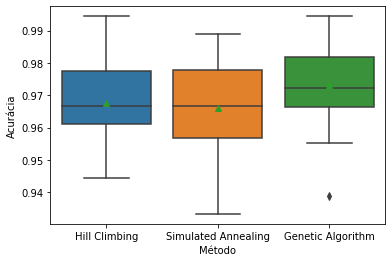

In [ ]:
#Resultados obtidos da base de dados Digits
print("Resultados da base de dados Digits:\n")
showResults(digits_results)

Resultados da base de dados Wine:



                Método     Média        DP        LI        LS
0        Hill Climbing  0.977560  0.042540  0.962337  0.992782
1  Simulated Annealing  0.971786  0.049930  0.953920  0.989653
2    Genetic Algorithm  0.964052  0.052213  0.945369  0.982736


               0                    1                  2
0  Hill Climbing              0.31955          0.0680513
1       0.287787  Simulated Annealing           0.204871
2      0.0481935              0.16053  Genetic Algorithm




/home/fsantos/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


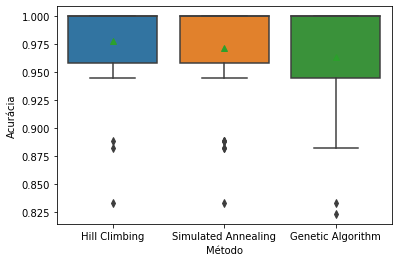

In [ ]:
#Resultados obtidos da base de dados Wine
print("Resultados da base de dados Wine:\n")
showResults(wine_results)

Resultados da base de dados Breast Cancer:



                Método     Média        DP        LI        LS
0        Hill Climbing  0.949091  0.029105  0.938676  0.959507
1  Simulated Annealing  0.954898  0.024284  0.946208  0.963588
2    Genetic Algorithm  0.956662  0.025940  0.947380  0.965945


               0                    1                  2
0  Hill Climbing             0.221619          0.0580133
1       0.221905  Simulated Annealing           0.691504
2      0.0997907             0.921662  Genetic Algorithm




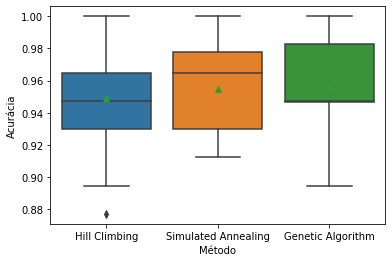

In [ ]:
#Resultados obtidos da base de dados Breast Cancer
print("Resultados da base de dados Breast Cancer:\n")
showResults(breast_cancer_results)